In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from statsmodels.tsa import ar_model, arima_model, tsatools
from sklearn.linear_model import LinearRegression

In [2]:
def SR(x):
    return (np.mean(x)/np.std(x)) * np.sqrt(252.0)

def WN(size):
    return pd.DataFrame({"WN": np.random.normal(size=size)})

def WN_Returns(size, scale):
    return pd.DataFrame({"WN": np.random.normal(size=size, scale=scale)})

def TSCV(index, window_size, warmup_size, expanding=True):
    n_windows = int(np.floor((len(index) - warmup_size)/window_size))
    tscv_folds = {"insample": {}, "outsample": {}}
    for i in range(n_windows):
        if expanding:
            tscv_folds["insample"][str(i)] = index[:warmup_size+i*window_size]
            tscv_folds["outsample"][str(i)] = index[warmup_size+i*window_size:warmup_size+(i+1)*window_size]
            
    # last bit
    if expanding:
        tscv_folds["insample"][str(i+1)] = index[:warmup_size+(i+1)*window_size]
        tscv_folds["outsample"][str(i+1)] = index[warmup_size+(i+1)*window_size:]
        
    return tscv_folds

def df_ewma(ts, spans):
    df = ts.ewm(span=spans[0]).mean()
    df.columns = ["span_" + str(spans[0])]
    for span in spans[1:]:
        data = ts.ewm(span=span).mean()
        data.columns = ["span_" + str(span)]
        df = pd.concat([df, data], axis=1)
        
    return df

def df_lags(ts, lags):
    df = ts.shift(lags[0])
    df.columns = ["lag_" + str(lags[0])]
    for lag in lags[1:]:
        data = ts.shift(lag)
        data.columns = ["lag_" + str(lag)]
        df = pd.concat([df, data], axis=1)
        
    return df

# Mult Hyp Test vs Perf Eval Diff

In [ ]:
# evaluating well performance, or estimating better generalization error can be gamed, 
# mainly if it is a fixed approached (window based)

## Data and Params

In [70]:
# data params
data_size = 12000
wn_scale = 0.01
ts_shift = 1

# cv params
holdout_size = 2000
warmup_size = 5000
window_size = 1000
expanding = True

# model params
pred_model = LinearRegression()
ewmas_span = np.arange(3, 100).tolist()
lags_values = np.arange(0, 100).tolist()

# data
ts = WN_Returns(data_size, scale=wn_scale)
ts_target = ts[ts_shift:].copy()
ts_input = ts.shift(ts_shift).dropna()

# ts_input = df_ewma(ts_input, ewmas_span)
ts_input = df_lags(ts_input, lags_values)

ts = pd.concat([ts_target, ts_input], axis=1).dropna()
avail_featlist = list(ts_input.columns)
ts.columns = ["target"] + avail_featlist

# cv folds
ts_folds = TSCV(list(ts.index)[:-holdout_size], window_size, warmup_size, expanding)
ts_folds["holdout"] = list(ts.index)[-holdout_size:]

## Feature Selection using Lags - Fixed TSCV

In [92]:
av_featlist = np.copy(avail_featlist).tolist()
tentative_list = []
fixed_list = []
max_fslist = 20
k = 0
df_results = pd.DataFrame(index=[0], columns=["Iter", "InCV SR", "OutCV SR", "Hold SR", "Max InCV SR", "Max Hold SR", 
                                              "Long-only SR", "FS"])

while len(av_featlist) != 0 and len(fixed_list) <= max_fslist:
    
    insr_fs, outsr_fs, holdsr_fs = [], [], []
    for fs in av_featlist:
        # feature list
        feat_list = fixed_list + [fs]
        outsample_pred, outsample_obs = np.array([]), np.array([])
        
        # model and prediction
        for fold_num in range(len(ts_folds["insample"].keys())):
            # fit model
            ml = pred_model.fit(ts.loc[ts_folds["insample"][str(fold_num)], feat_list], 
                                ts.loc[ts_folds["insample"][str(fold_num)], "target"])
            
            # prediction and obs
            outsample_pred = np.concatenate([outsample_pred, 
                                             ml.predict(ts.loc[ts_folds["outsample"][str(fold_num)], feat_list])])
            outsample_obs = np.concatenate([outsample_obs, 
                                            ts.loc[ts_folds["outsample"][str(fold_num)], "target"]])
            
        # compute performance
        insr_fs.append(SR(ml.predict(ts.loc[ts_folds["insample"][str(fold_num)], feat_list]) * 
                         ts.loc[ts_folds["insample"][str(fold_num)], "target"]))
        outsr_fs.append(SR(outsample_pred * outsample_obs))
        holdsr_fs.append(SR(ml.predict(ts.loc[ts_folds["holdout"], feat_list]) * 
                         ts.loc[ts_folds["holdout"], "target"]))
            
    # get best feature and remove from available list
    get_fs = av_featlist[np.argmax(outsr_fs)]
    fixed_list += [get_fs]
    av_featlist.pop(np.argmax(outsr_fs))

    # store results
    df_results.loc[k, "Iter"] = k
    df_results.loc[k, "InCV SR"] = insr_fs[np.argmax(outsr_fs)]
    df_results.loc[k, "OutCV SR"] = np.max(outsr_fs)
    df_results.loc[k, "Hold SR"] = holdsr_fs[np.argmax(outsr_fs)]
    df_results.loc[k, "FS"] = np.copy(fixed_list)
    df_results.loc[k, "Max InCV SR"] = np.max(insr_fs)
    df_results.loc[k, "Max Hold SR"] = np.max(holdsr_fs)
    df_results.loc[k, "Long-only SR"] = SR(ts["target"].values)
    k += 1
    print(k, insr_fs[np.argmax(outsr_fs)], np.max(outsr_fs), holdsr_fs[np.argmax(outsr_fs)])
    print(fixed_list)         

1 0.5355882464342318 0.6658236135315686 0.2984536044556053
['lag_6']
2 0.5978561482409529 0.7540912810035096 0.4187323610275606
['lag_6', 'lag_5']
3 0.6894332729488856 0.8249723899110659 0.14924599948482023
['lag_6', 'lag_5', 'lag_70']
4 0.7308107324666885 0.8880702997706887 0.16718223764952833
['lag_6', 'lag_5', 'lag_70', 'lag_36']
5 0.8165358182907828 0.9479729165851418 -0.06499155801767956
['lag_6', 'lag_5', 'lag_70', 'lag_36', 'lag_91']
6 0.8499048692942476 0.9950218882398109 0.049925457112437406
['lag_6', 'lag_5', 'lag_70', 'lag_36', 'lag_91', 'lag_9']
7 0.8740128636193719 1.0362706752209896 0.19561736491725368
['lag_6', 'lag_5', 'lag_70', 'lag_36', 'lag_91', 'lag_9', 'lag_64']
8 0.9155335739636423 1.0698402980809318 0.14991972408792806
['lag_6', 'lag_5', 'lag_70', 'lag_36', 'lag_91', 'lag_9', 'lag_64', 'lag_37']
9 0.9349574090623226 1.0975569054915857 0.13477987476508585
['lag_6', 'lag_5', 'lag_70', 'lag_36', 'lag_91', 'lag_9', 'lag_64', 'lag_37', 'lag_52']
10 0.9477383425483566 

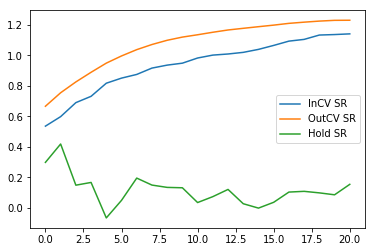

In [93]:
df_results.loc[:20, ["InCV SR", "OutCV SR", "Hold SR"]].plot()

## Feature Selection with Lags - Random Subsets for Every Turn

In [86]:
av_featlist = np.copy(avail_featlist).tolist()
tentative_list = []
fixed_list = []
rsubsets = 4
max_fslist = 20
k = 0
df_results = pd.DataFrame(index=[0], columns=["Iter", "InCV SR", "OutCV SR", "Hold SR", "Max InCV SR", "Max Hold SR", 
                                              "Long-only SR", "FS"])

while len(av_featlist) != 0 and len(fixed_list) <= max_fslist:
    
    insr_fs, outsr_fs, holdsr_fs = [], [], []
    random_tscv = np.random.permutation(range(len(ts_folds["insample"].keys())))[:rsubsets].tolist()
    for fs in av_featlist:
        # feature list
        feat_list = fixed_list + [fs]
        outsample_pred, outsample_obs = np.array([]), np.array([])
        
        # model and prediction
        for fold_num in np.sort(random_tscv):
            # fit model
            ml = pred_model.fit(ts.loc[ts_folds["insample"][str(fold_num)], feat_list], 
                                ts.loc[ts_folds["insample"][str(fold_num)], "target"])
            
            # prediction and obs
            outsample_pred = np.concatenate([outsample_pred, 
                                             ml.predict(ts.loc[ts_folds["outsample"][str(fold_num)], feat_list])])
            outsample_obs = np.concatenate([outsample_obs, 
                                            ts.loc[ts_folds["outsample"][str(fold_num)], "target"]])
            
        # compute performance
        insr_fs.append(SR(ml.predict(ts.loc[ts_folds["insample"][str(fold_num)], feat_list]) * 
                         ts.loc[ts_folds["insample"][str(fold_num)], "target"]))
        outsr_fs.append(SR(outsample_pred * outsample_obs))
        holdsr_fs.append(SR(ml.predict(ts.loc[ts_folds["holdout"], feat_list]) * 
                         ts.loc[ts_folds["holdout"], "target"]))
            
    # get best feature and remove from available list
    get_fs = av_featlist[np.argmax(outsr_fs)]
    fixed_list += [get_fs]
    av_featlist.pop(np.argmax(outsr_fs))

    # store results
    df_results.loc[k, "Iter"] = k
    df_results.loc[k, "InCV SR"] = insr_fs[np.argmax(outsr_fs)]
    df_results.loc[k, "OutCV SR"] = np.max(outsr_fs)
    df_results.loc[k, "Hold SR"] = holdsr_fs[np.argmax(outsr_fs)]
    df_results.loc[k, "FS"] = np.copy(fixed_list)
    df_results.loc[k, "Max InCV SR"] = np.max(insr_fs)
    df_results.loc[k, "Max Hold SR"] = np.max(holdsr_fs)
    df_results.loc[k, "Long-only SR"] = SR(ts["target"].values)
    k += 1
    print(k, insr_fs[np.argmax(outsr_fs)], np.max(outsr_fs), holdsr_fs[np.argmax(outsr_fs)])
    print(fixed_list)         

1 0.45945492822242284 0.7291700786286394 0.2718526693324954
['lag_16']
2 0.5592074449070475 0.9504030658400238 0.2901476968068395
['lag_16', 'lag_6']
3 0.6076657359541998 1.0144133018066086 0.3985114967749481
['lag_16', 'lag_6', 'lag_19']
4 0.6462415494491179 1.0997397725884535 0.42775445170420284
['lag_16', 'lag_6', 'lag_19', 'lag_29']
5 0.6557501524011783 1.1355938314371712 0.4852237400972798
['lag_16', 'lag_6', 'lag_19', 'lag_29', 'lag_35']
6 0.6860672766378125 1.1928954237331693 0.6424930933780707
['lag_16', 'lag_6', 'lag_19', 'lag_29', 'lag_35', 'lag_64']
7 0.7284663875169067 1.24507383856633 0.6387562567836867
['lag_16', 'lag_6', 'lag_19', 'lag_29', 'lag_35', 'lag_64', 'lag_36']
8 0.7733791564216936 1.3773559811562073 0.7119366242413215
['lag_16', 'lag_6', 'lag_19', 'lag_29', 'lag_35', 'lag_64', 'lag_36', 'lag_5']
9 0.8226506963771062 1.4101229838710636 0.6382240718281305
['lag_16', 'lag_6', 'lag_19', 'lag_29', 'lag_35', 'lag_64', 'lag_36', 'lag_5', 'lag_37']
10 0.860367873495598

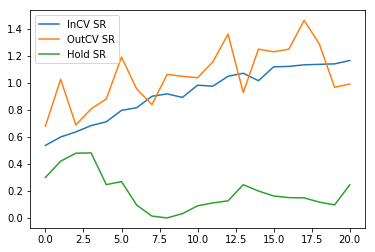

In [85]:
df_results.loc[:20, ["InCV SR", "OutCV SR", "Hold SR"]].plot()

## Feature Selection using Lags - Random subsets different for every feature attempted

In [32]:
av_featlist = np.copy(avail_featlist).tolist()
tentative_list = []
fixed_list = []
rsubsets = 4
max_fslist = 20
k = 0
df_results = pd.DataFrame(index=[0], columns=["Iter", "InCV SR", "OutCV SR", "Hold SR", "Max InCV SR", "Max Hold SR", 
                                              "Long-only SR", "FS"])

while len(av_featlist) != 0 and len(fixed_list) <= max_fslist:
    
    insr_fs, outsr_fs, holdsr_fs = [], [], []
    for fs in av_featlist:
        # feature list
        feat_list = fixed_list + [fs]
        outsample_pred, outsample_obs = np.array([]), np.array([])
        
        # model and prediction
        random_tscv = np.random.permutation(range(len(ts_folds["insample"].keys())))[:rsubsets].tolist()
        for fold_num in np.sort(random_tscv):
            # fit model
            ml = pred_model.fit(ts.loc[ts_folds["insample"][str(fold_num)], feat_list], 
                                ts.loc[ts_folds["insample"][str(fold_num)], "target"])
            
            # prediction and obs
            outsample_pred = np.concatenate([outsample_pred, 
                                             ml.predict(ts.loc[ts_folds["outsample"][str(fold_num)], feat_list])])
            outsample_obs = np.concatenate([outsample_obs, 
                                            ts.loc[ts_folds["outsample"][str(fold_num)], "target"]])
            
        # compute performance
        insr_fs.append(SR(ml.predict(ts.loc[ts_folds["insample"][str(fold_num)], feat_list]) * 
                         ts.loc[ts_folds["insample"][str(fold_num)], "target"]))
        outsr_fs.append(SR(outsample_pred * outsample_obs))
        holdsr_fs.append(SR(ml.predict(ts.loc[ts_folds["holdout"], feat_list]) * 
                         ts.loc[ts_folds["holdout"], "target"]))
            
    # get best feature and remove from available list
    get_fs = av_featlist[np.argmax(outsr_fs)]
    fixed_list += [get_fs]
    av_featlist.pop(np.argmax(outsr_fs))

    # store results
    df_results.loc[k, "Iter"] = k
    df_results.loc[k, "InCV SR"] = insr_fs[np.argmax(outsr_fs)]
    df_results.loc[k, "OutCV SR"] = np.max(outsr_fs)
    df_results.loc[k, "Hold SR"] = holdsr_fs[np.argmax(outsr_fs)]
    df_results.loc[k, "FS"] = np.copy(fixed_list)
    df_results.loc[k, "Max InCV SR"] = np.max(insr_fs)
    df_results.loc[k, "Max Hold SR"] = np.max(holdsr_fs)
    df_results.loc[k, "Long-only SR"] = SR(ts["target"].values)
    k += 1
    print(k, insr_fs[np.argmax(outsr_fs)], np.max(outsr_fs), holdsr_fs[np.argmax(outsr_fs)])
    print(fixed_list)         

1 0.21634362282799696 0.8552839656636296 -0.2907035159689069
['lag_53']
2 0.47896802806537575 0.9464614887266207 -0.1381022295488723
['lag_53', 'lag_86']
3 0.4399090695129984 0.913733428212416 -0.24840932444264077
['lag_53', 'lag_86', 'lag_65']
4 0.48712428677494424 1.1329937258806293 -0.22464084802835385
['lag_53', 'lag_86', 'lag_65', 'lag_42']
5 0.5107940190665712 1.035396350330046 -0.21939986939344333
['lag_53', 'lag_86', 'lag_65', 'lag_42', 'lag_91']
6 0.5308013796007955 1.187020995041458 -0.2323637943140896
['lag_53', 'lag_86', 'lag_65', 'lag_42', 'lag_91', 'lag_37']
7 0.5741792873806427 1.2476928700331853 -0.3200994980470945
['lag_53', 'lag_86', 'lag_65', 'lag_42', 'lag_91', 'lag_37', 'lag_50']
8 0.5947032166022195 1.4466844313669953 -0.38050658797544407
['lag_53', 'lag_86', 'lag_65', 'lag_42', 'lag_91', 'lag_37', 'lag_50', 'lag_6']
9 0.6043689561136064 1.3008700703251677 -0.3597249212121747
['lag_53', 'lag_86', 'lag_65', 'lag_42', 'lag_91', 'lag_37', 'lag_50', 'lag_6', 'lag_3']


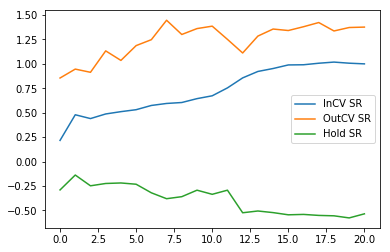

In [33]:
df_results.loc[:20, ["InCV SR", "OutCV SR", "Hold SR"]].plot()